In [1]:
import glob, json, os 
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize  # 用于数据归一化处理
import matplotlib.pyplot as plt

img_paths = glob.glob('/Users/wangyingyue/materials/大模型学习资料——八斗/homework/week10/image_caption/image/*.jpg')
img_paths.sort()


In [2]:
"""
加载图像描述任务的验证集标注数据
"""
validation_annotations = json.load(
    open('/Users/wangyingyue/materials/大模型学习资料——八斗/homework/week10/image_caption/description.json')
)

validation_annotations[:2]  # 查看前两条标注数据

[{'image_id': '1.jpg', 'caption': '有几家街头小吃摊，卖着油炸小吃，一位穿格子衫的男子拿着面粉，周围还有其他顾客和摊主'},
 {'image_id': '2.jpg',
  'caption': '一个女孩穿着白色公主裙，头上戴着天使发饰，和坐在椅子上的男子说笑，后面有一些人在忙碌着'}]

In [3]:
validation_annotations_dict = {x['image_id']: x['caption'] for x in validation_annotations}
validation_annotations_dict

{'1.jpg': '有几家街头小吃摊，卖着油炸小吃，一位穿格子衫的男子拿着面粉，周围还有其他顾客和摊主',
 '2.jpg': '一个女孩穿着白色公主裙，头上戴着天使发饰，和坐在椅子上的男子说笑，后面有一些人在忙碌着',
 '3.jpg': '一个女人骑着电瓶车，后座坐着一个男人拉着手推车，手推车上有一个小婴儿',
 '4.jpg': '一位戴眼镜的男士蹲在类似机器狗的机械装置旁',
 '5.jpg': '一位男士站在前面，四位女孩在他身后，背景是古朴的巷子',
 '6.jpg': '一只大狗狗趴在地上，头上落了一片黄色的树叶',
 '7.jpg': '一位头发花白的外国老人站在一家杂货店的玻璃窗前向里看',
 '8.jpg': '五名儿童在火车车厢中吃着泡面',
 '9.jpg': '一名穿着红色球衣和一名穿着白色球衣的排球运动员在球网上方激烈对抗',
 '10.jpg': '有两只长颈鹿向栅栏外探头，还有一只鸵鸟'}

In [4]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]  # 提取所有的文件名
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

In [5]:
len(img_captions)

10

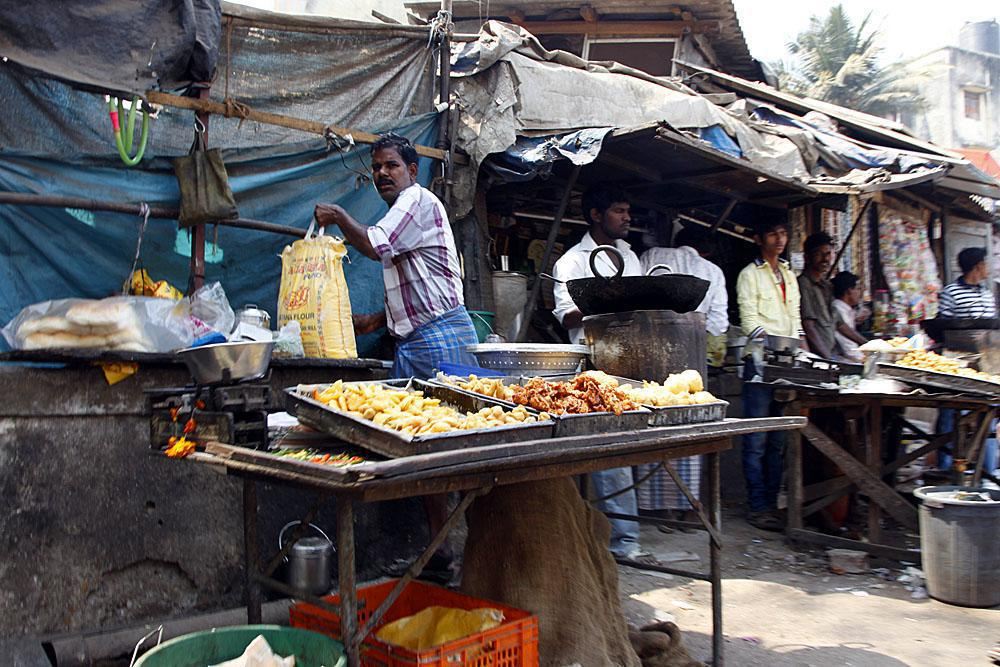

In [6]:
Image.open(img_paths[0])

In [7]:
img_captions[0]

'有几家街头小吃摊，卖着油炸小吃，一位穿格子衫的男子拿着面粉，周围还有其他顾客和摊主'

# 加载CLIP模型

In [8]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

model = ChineseCLIPModel.from_pretrained("/Users/wangyingyue/materials/大模型学习资料——八斗/models/chinese-clip-vit-base-patch16") # 中文clip模型
# 预处理工具
processor = ChineseCLIPProcessor.from_pretrained("/Users/wangyingyue/materials/大模型学习资料——八斗/models/chinese-clip-vit-base-patch16") # 预处理


/opt/miniconda3/envs/clip-env/lib/python3.8/site-packages/transformers/modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file

# 图像编码

In [9]:
from tqdm.notebook import tqdm_notebook

img_image_feat = [] 

for idx in tqdm_notebook(range(len(img_captions))):
    imgs = Image.open(img_paths[idx])
    imgs = [imgs]
    
    inputs = processor(images=imgs, return_tensors="pt")

    with torch.no_grad():
        image_features = model.get_image_features(**inputs)  
        image_features = image_features.data.numpy()  
        img_image_feat.append(image_features)
        
img_image_feat = np.vstack(img_image_feat) 
img_image_feat = normalize(img_image_feat) 


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
img_image_feat.shape 

(10, 512)

# 文本编码

In [11]:
"""
用中文 CLIP 的文本编码器批量提取文本描述的特征向量，并归一化
"""
img_texts_feat = []

for idx in tqdm_notebook(range(len(img_captions))):
    text = img_captions[idx]
    text = [text]

    inputs = processor(text=text, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)

        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)


  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
img_texts_feat.shape

(10, 512)

# 尝试1：相似度计算

In [13]:
"""
实现 “文本到图像的检索”
"""
query_idx = 5

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) 
sim_idx = sim_result.argsort()[::-1][1:4] 

输入文本:  一位男士站在前面，四位女孩在他身后，背景是古朴的巷子


([], [])

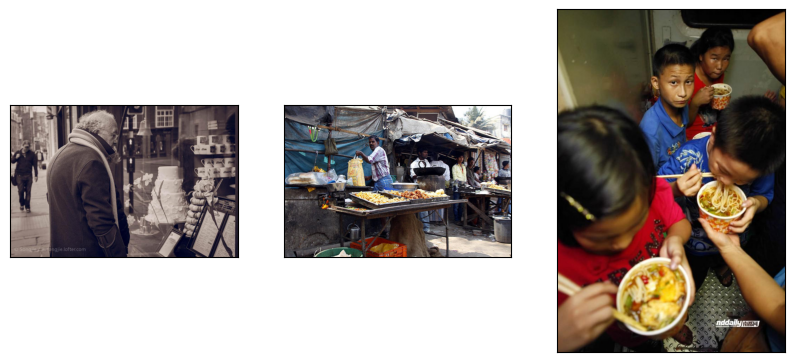

In [14]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [15]:
"""
实现 “图像到文本的检索”
"""
query_idx = 9

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

文本识别结果:  ['有两只长颈鹿向栅栏外探头，还有一只鸵鸟', '一位男士站在前面，四位女孩在他身后，背景是古朴的巷子', '一位戴眼镜的男士蹲在类似机器狗的机械装置旁']


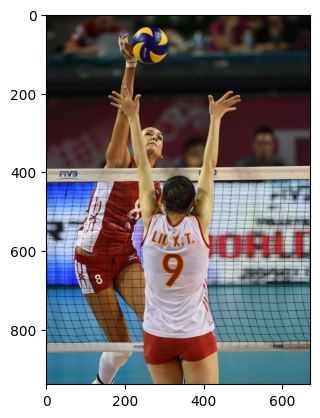

In [16]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [17]:
import jieba

In [18]:
jieba.lcut(img_captions[0])

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/0k/nqx394z17lz7qy2q2xczsx2m0000gn/T/jieba.cache
Loading model cost 0.191 seconds.
Prefix dict has been built successfully.


['有',
 '几家',
 '街头',
 '小吃摊',
 '，',
 '卖',
 '着',
 '油炸',
 '小吃',
 '，',
 '一位',
 '穿',
 '格子',
 '衫',
 '的',
 '男子',
 '拿',
 '着',
 '面粉',
 '，',
 '周围',
 '还有',
 '其他',
 '顾客',
 '和',
 '摊主']

In [19]:
"""
从文本描述中提取关键词（词语），并为每个词语生成特征向量
"""
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])  # 将 “列表的列表” 扁平化为一个单一列表，包含所有文本描述中出现的词语

In [20]:
img_captions2words[:10]

['有', '几家', '街头', '小吃摊', '，', '卖', '着', '油炸', '小吃', '，']

In [21]:
"""
过滤短词并去重
"""
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [22]:
img_captions2words[:10]

['玻璃窗', '一些', '狗狗', '男人', '婴儿', '巷子', '公主', '杂货店', '外国', '顾客']

In [23]:
img_texts_feat = []

for idx in tqdm_notebook(range(len(img_captions2words))):
    text = img_captions2words[idx]
    text = [text]

    inputs = processor(text=text, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)


  0%|          | 0/80 [00:00<?, ?it/s]

# 尝试2：标签相似度计算

In [24]:
"""
图像到关键词的检索
"""
query_idx = 9

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

文本识别结果:  ['激烈', '球网', '对抗', '拉着', '头上', '外国']


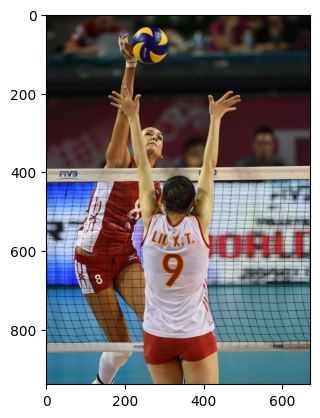

In [25]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])